In [1]:
using GLM
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatisticalRethinking
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

Code 6.1

In [2]:
Random.seed!(1917)
N = 200   # grant proposals
p = 0.1   # proportion to select

# uncorrelated newsworthiness and trustworthiness
nw = rand(Normal(), N)
tw = rand(Normal(), N)

# select top 10% of combined score
s = nw .+ tw
q = quantile(s, 1-p)
selected = s .>= q
cor(tw[selected], nw[selected])

-0.785212889969301

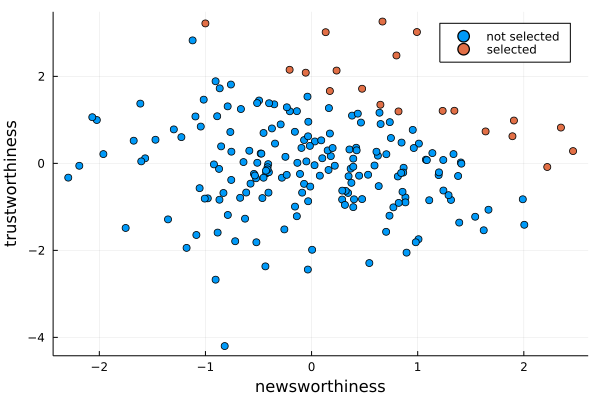

In [3]:
scatter(nw[.!selected], tw[.!selected]; xlab="newsworthiness", ylab="trustworthiness", label="not selected")
scatter!(nw[selected], tw[selected]; label="selected")

# 6.1 Multicollinearity

Code 6.2

In [4]:
Random.seed!(100)
N = 100
height = rand(Normal(10, 2), N)
leg_prop = rand(Uniform(0.4, 0.5), N)
leg_left = leg_prop .* height .+ rand(Normal(0, 0.02), N)
leg_right = leg_prop .* height .+ rand(Normal(0, 0.02), N)
d = DataFrame(:height => height, :leg_left => leg_left, :leg_right => leg_right);

Code 6.3

In [5]:
@model function model_m6_1(leg_left, leg_right, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    br ~ Normal(2, 10)
    μ = @. a + bl * leg_left + br * leg_right
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_1 = sample(model_m6_1(d.leg_left, d.leg_right, d.height), NUTS(), 1000)
m6_1_df = DataFrame(m6_1)
precis(m6_1_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%      histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.6338  0.3296    0.091  0.6329  1.1752   ▁▁▁▃▅██▆▃▂▁▁ │
│    bl │ 1.7655    1.96  -1.4323  1.8123  4.8364  ▁▁▂▂▅▇██▅▄▂▁▁ │
│    br │ 0.3122  1.9688   -2.772  0.2748  3.4925  ▁▁▂▄▅██▇▅▃▂▁▁ │
│     σ │ 0.6126  0.0449   0.5446  0.6099  0.6885         ▂▇█▃▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 6.4

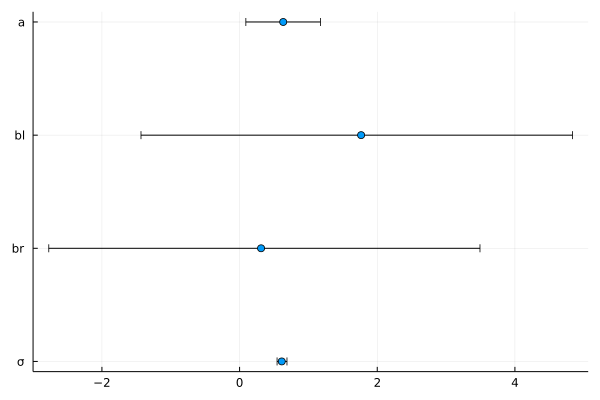

In [6]:
coeftab_plot(m6_1_df)

Code 6.5

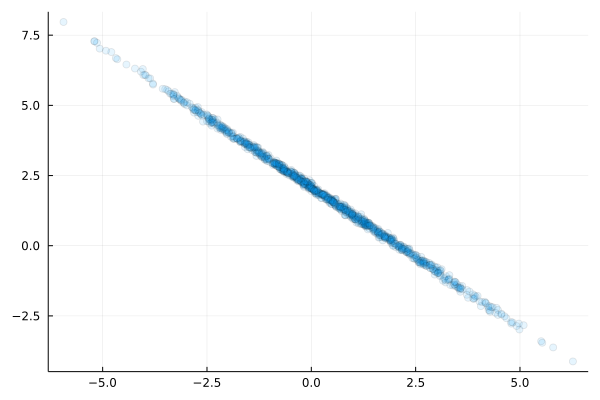

In [7]:
scatter(m6_1_df.br, m6_1_df.bl; alpha=0.1)

Code 6.6

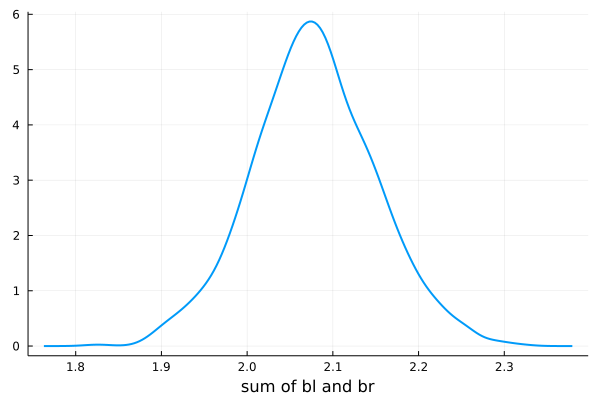

In [8]:
@df m6_1_df density(:br + :bl; lw=2, xlab="sum of bl and br")

Code 6.7

In [9]:
@model function model_m6_2(leg_left, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    μ = @. a + bl * leg_left
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_2 = sample(model_m6_2(d.leg_left, d.height), NUTS(), 1000)
m6_2_df = DataFrame(m6_2)
precis(m6_2_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%       histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.6728   0.327  0.1407  0.6611  1.1928    ▁▁▁▂▅▇█▇▄▂▁▁ │
│    bl │ 2.0684  0.0712   1.956  2.0689  2.1783      ▁▁▂▄▇█▆▃▁▁ │
│     σ │ 0.6063  0.0414  0.5434  0.6051  0.6753  ▁▁▂▄▇██▆▄▃▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


In [10]:
std(m6_1_df.bl), std(m6_1_df.br), std(m6_1_df.bl + m6_1_df.br)

(1.9600064957206784, 1.9687730215545687, 0.07174624055531233)

Code 6.8

In [11]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:F] = standardize(ZScoreTransform, d.perc_fat)
d[!,:L] = standardize(ZScoreTransform, d.perc_lactose);

Code 6.9

In [12]:
@model function model_m6_3(F, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    μ = @. a + F * bF
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_3 = sample(model_m6_3(d.F, d.K), NUTS(), 1000)
m6_3_df = DataFrame(m6_3)

@model function model_m6_4(L, K)
    a ~ Normal(0, 0.2)
    bL ~ Normal(0, 0.5)
    μ = @. a + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_4 = sample(model_m6_4(d.L, d.K), NUTS(), 1000)
m6_4_df = DataFrame(m6_4)

precis(m6_3_df)
precis(m6_4_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%      histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │ -0.0019  0.0858  -0.1392  -0.002  0.1269  ▁▁▁▃▅██▆▃▁▁▁▁ │
│    bF │  0.8528  0.0898    0.695  0.8562  0.9923   ▁▁▂▃▆██▇▃▂▁▁ │
│     σ │  0.4901  0.0666    0.396  0.4851  0.6026    ▁▂▇█▆▄▂▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘
┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │ -0.0009  0.0733  -0.1186   0.0022   0.1182  ▁▁▁▂▅██▅▂▁▁▁ │
│    bL │ -0.8944  0.0762  -1.0148  -0.8951  -0.7735      ▁▂██▂▁▁▁ │
│     σ │  0.4124  0.0597    0.328   0.4058   0.5152    ▁▄██▄▂▁▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 6.10

In [13]:
@model function model_m6_5(F, L, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    bL ~ Normal(0, 0.5)
    μ = @. a + F * bF + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_5 = sample(model_m6_5(d.F, d.L, d.K), NUTS(), 1000)
m6_5_df = DataFrame(m6_5)
precis(m6_5_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ -0.0002  0.0749  -0.1122   -0.001  0.1187   ▁▁▁▁▃▆██▅▃▁▁▁ │
│    bF │   0.268  0.2011  -0.0516   0.2635  0.5871        ▁▁▂▆█▅▁▁ │
│    bL │ -0.6537   0.196  -0.9458  -0.6601  -0.321  ▁▁▁▁▃▅██▇▅▃▂▁▁ │
│     σ │  0.4153  0.0604    0.333   0.4078  0.5214      ▁▃██▄▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 6.11

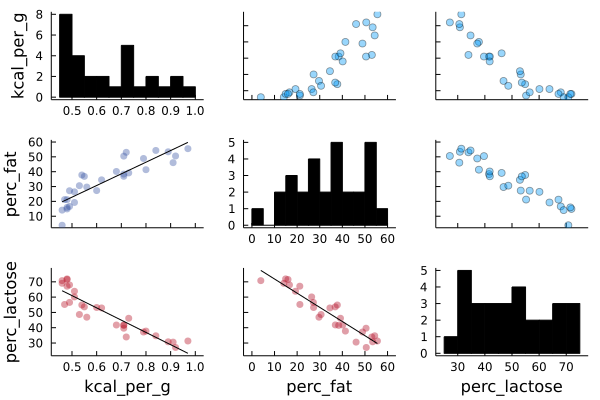

In [14]:
@df d corrplot([:kcal_per_g :perc_fat :perc_lactose]; seriestype=:scatter, bins=10, grid=false)

Code 6.12

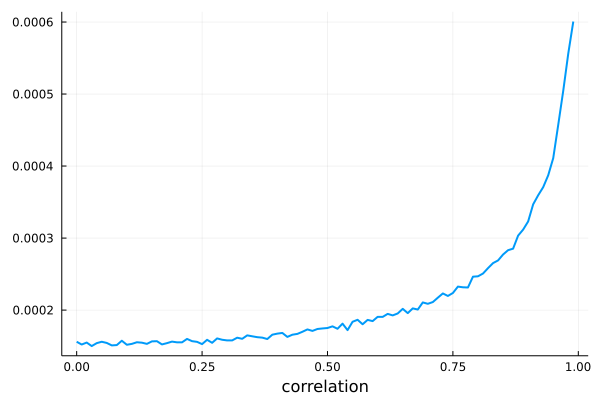

In [15]:
# get mean stderr for linear model's scale
function stderr_for_r(r)
    σ = sqrt(1-r^2)*var(d.perc_fat)
    fat_scaled = r .* d.perc_fat
    stderr_x = [
        begin
            x = d.perc_fat .+ rand(MvNormal(fat_scaled, σ))
            # add the intercept to the model
            X = hcat(ones(length(x)), x)
            m = lm(X, d.kcal_per_g)
            stderror(m)[2]
        end
        for _ in 1:100
    ]
    s = mean(stderr_x)
end

r_seq = range(0, 0.99; step=0.01)
s = stderr_for_r.(r_seq)
plot(r_seq, s; lw=2, xlab="correlation")

# 6.2 Post-treatment bias

Code 6.13

In [16]:
Random.seed!(70)
# number of plants
N = 100
h0 = rand(Normal(10, 2), N)
treatment = repeat(0:1, inner=div(N, 2))
fungus = [rand(Binomial(1, 0.5 - treat*0.4)) for treat in treatment]
h1 = h0 .+ rand(MvNormal(5 .- 3 .* fungus, 1))

d = DataFrame(:h0 => h0, :h1 => h1, :treatment => treatment, :fungus => fungus)
precis(d)

┌───────────┬───────────────────────────────────────────────────────────┐
│     param │    mean     std     5.5%     50%    94.5%       histogram │
├───────────┼───────────────────────────────────────────────────────────┤
│        h0 │  9.9795   1.915    7.281  9.7521  13.2437     ▁▂▃▅█▆▃▃▂▁▁ │
│        h1 │ 14.0642   2.561  10.2762  13.961  17.7881  ▁▁▂▃▄█▅▆▃▅▅▁▁▁ │
│ treatment │     0.5  0.5025      0.0     0.5      1.0     █▁▁▁▁▁▁▁▁▁█ │
│    fungus │    0.32  0.4688      0.0     0.0      1.0     █▁▁▁▁▁▁▁▁▁▄ │
└───────────┴───────────────────────────────────────────────────────────┘


Code 6.14

In [17]:
sim_p = rand(LogNormal(0, 0.25), 10_000)
precis(DataFrame(:sim_p => sim_p))

┌───────┬───────────────────────────────────────────────────┐
│ param │   mean    std    5.5%     50%   94.5%   histogram │
├───────┼───────────────────────────────────────────────────┤
│ sim_p │ 1.0377  0.265  0.6718  1.0041  1.4985  ▁▄█▇▄▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────┘


Code 6.15

In [18]:
@model function model_m6_6(h0, h1)
    p ~ LogNormal(0, 0.25)
    σ ~ Exponential(1)
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_6 = sample(model_m6_6(d.h0, d.h1), NUTS(), 1000)
m6_6_df = DataFrame(m6_6)
precis(m6_6_df)

┌───────┬─────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%    histogram │
├───────┼─────────────────────────────────────────────────────┤
│     p │ 1.3938  0.0182  1.3654  1.3939  1.4231  ▁▁▃▆▇██▅▃▁▁ │
│     σ │ 1.8391  0.1276    1.65  1.8313  2.0472  ▁▁▃██▆▂▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────┘


Code 6.16

In [19]:
@model function model_m6_7(h0, treatment, fungus, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    bf ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment + bf*fungus
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_7 = sample(model_m6_7(d.h0, d.treatment, d.fungus, d.h1), NUTS(), 1000)
m6_7_df = DataFrame(m6_7)
precis(m6_7_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%      50%    94.5%     histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │ 1.4831  0.0212   1.4501   1.4832   1.5167       ▁▁▃▇█▅▁ │
│    bt │ 0.0133   0.025  -0.0261   0.0137   0.0531     ▁▁▂▆█▇▃▁▁ │
│    bf │  -0.28  0.0262  -0.3218  -0.2807  -0.2372     ▁▂▅██▅▂▁▁ │
│     σ │ 1.2092  0.0863   1.0834   1.2026   1.3517  ▁▃███▆▄▂▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


Code 6.17

In [20]:
@model function model_m6_8(h0, treatment, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_8 = sample(model_m6_8(d.h0, d.treatment, d.h1), NUTS(), 1000)
m6_8_df = DataFrame(m6_8)
precis(m6_8_df)

┌───────┬─────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%    histogram │
├───────┼─────────────────────────────────────────────────────┤
│     a │ 1.3323  0.0229  1.2955   1.332  1.3666     ▁▂▆█▇▃▁▁ │
│    bt │  0.124  0.0319  0.0725  0.1254  0.1729  ▁▁▂▅▇█▆▃▁▁▁ │
│     σ │ 1.7317  0.1283  1.5444  1.7245  1.9556   ▁▁▄██▅▂▁▁▁ │
└───────┴─────────────────────────────────────────────────────┘


Code 6.18

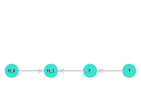

In [24]:
plant_dag = Dagitty.DAG(:H_0 => :H_1, :F => :H_1, :T => :F)
drawdag(plant_dag, [2, 0, 1, 3], [0, 0, 0, 0])

Code 6.19

In [23]:
implied_conditional_independencies_min(plant_dag)

3-element Vector{ConditionalIndependence}:
 ConditionalIndependence(:F, :H_0, Symbol[])
 ConditionalIndependence(:H_0, :T, Symbol[])
 ConditionalIndependence(:H_1, :T, [:F])

Code 6.20

In [30]:
Random.seed!(70)
# number of plants
N = 1000
h0 = rand(Normal(10, 2), N)
treatment = repeat(0:1, inner=div(N, 2))
M = rand(Bernoulli(), N)
fungus = [
    rand(Binomial(1, 0.5 - treat*0.4 + 0.4 * m)) 
    for (treat, m) ∈ zip(treatment, M)
]
h1 = h0 .+ rand(MvNormal(5 .+ 3 .* M, 1))

d2 = DataFrame(:h0 => h0, :h1 => h1, :treatment => treatment, :fungus => fungus)
precis(d2)

┌───────────┬────────────────────────────────────────────────────────────┐
│     param │    mean     std     5.5%      50%    94.5%       histogram │
├───────────┼────────────────────────────────────────────────────────────┤
│        h0 │ 10.0411  2.0531   6.7597   9.9194  13.2845  ▁▁▁▂▄▆█▇▆▄▂▁▁▁ │
│        h1 │ 16.5145  2.8202  12.0612  16.5204  21.1399       ▁▂▅▇█▆▃▁▁ │
│ treatment │     0.5  0.5003      0.0      0.5      1.0     █▁▁▁▁▁▁▁▁▁█ │
│    fungus │   0.511  0.5001      0.0      1.0      1.0     █▁▁▁▁▁▁▁▁▁█ │
└───────────┴────────────────────────────────────────────────────────────┘


In [29]:
m6_7 = sample(model_m6_7(d2.h0, d2.treatment, d2.fungus, d2.h1), NUTS(), 1000)
precis(DataFrame(m6_7))

┌───────┬────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%   histogram │
├───────┼────────────────────────────────────────────────────┤
│     a │ 1.5197  0.0131  1.4992  1.5194   1.541  ▁▁▂▅██▅▂▁▁ │
│    bt │ 0.0624  0.0137  0.0398  0.0618  0.0857   ▁▂▃██▆▃▁▁ │
│    bf │ 0.1339  0.0135  0.1123  0.1339  0.1556  ▁▁▁▃▇█▆▃▁▁ │
│     σ │ 2.0857  0.0453  2.0126   2.084  2.1589     ▁▁▄█▆▂▁ │
└───────┴────────────────────────────────────────────────────┘


In [28]:
m6_8 = sample(model_m6_8(d2.h0, d2.treatment, d2.h1), NUTS(), 1000)
precis(DataFrame(m6_8))

┌───────┬─────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%   histogram │
├───────┼─────────────────────────────────────────────────────┤
│     a │ 1.6182  0.0099   1.6031  1.6183   1.634   ▁▁▁▄█▆▂▁▁ │
│    bt │ 0.0044   0.014  -0.0175   0.004  0.0272  ▁▁▁▃▇█▇▃▁▁ │
│     σ │ 2.1748  0.0468   2.1016   2.174  2.2477     ▁▁▅█▅▁▁ │
└───────┴─────────────────────────────────────────────────────┘


# 6.3 Collider bias

Code 6.21

In [32]:
d = sim_happiness(seed=1977, n_years=1000)
precis(d)

┌───────────┬────────────────────────────────────────────────────────┐
│     param │   mean      std     5.5%   50%   94.5%       histogram │
├───────────┼────────────────────────────────────────────────────────┤
│       age │   33.0  18.7689      4.0  33.0    62.0  ▇████████████▂ │
│ happiness │   -0.0   1.2144  -1.7895   0.0  1.7895       █▆█▆▆█▆▆▃ │
│   married │ 0.2954   0.4564      0.0   0.0     1.0     █▁▁▁▁▁▁▁▁▁▄ │
└───────────┴────────────────────────────────────────────────────────┘


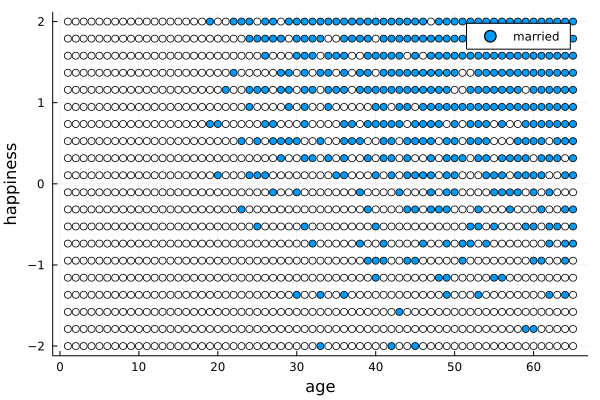

In [34]:
d_m = d[d.married .== 1,[:age,:happiness]]
d_u = d[d.married .== 0,[:age,:happiness]]

scatter(d_m.age, d_m.happiness; label="married", xlab="age", ylab="happiness")
scatter!(d_u.age, d_u.happiness; c=:white)

Code 6.22

In [37]:
d2 = d[d.age .> 17,:]
d2[!,:A] = @. (d2.age - 18) / (65-18);

Code 6.23

In [40]:
d2[!,:mid] = d2.married .+ 1;

In [42]:
@model function model_m6_9(mid, A, happiness)
    a ~ MvNormal([0, 0], 1)
    bA ~ Normal(0, 2)
    μ = a[mid] .+ bA .* A
    σ ~ Exponential(1)
    happiness ~ MvNormal(μ, σ)
end

m6_9 = sample(model_m6_9(d2.mid, d2.A, d2.happiness), NUTS(), 1000)
m6_9_df = DataFrame(m6_9)
precis(m6_9_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │ -0.2046   0.061  -0.3043  -0.2051  -0.1064      ▁▁▂▅█▇▄▂▁ │
│  a[2] │  1.2613  0.0846   1.1293   1.2613   1.4008  ▁▁▁▁▃▅██▆▃▂▁▁ │
│    bA │ -0.7649  0.1078    -0.93  -0.7657  -0.5951      ▁▁▂▇█▅▂▁▁ │
│     σ │  1.0048  0.0222   0.9695   1.0047    1.043       ▁▁▃██▄▂▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 6.24

In [43]:
@model function model_m6_10(A, happiness)
    a ~ Normal()
    bA ~ Normal(0, 2)
    μ = a .+ bA .* A
    σ ~ Exponential(1)
    happiness ~ MvNormal(μ, σ)
end

m6_10 = sample(model_m6_10(d2.A, d2.happiness), NUTS(), 1000)
m6_10_df = DataFrame(m6_10)
precis(m6_10_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%    histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ -0.0002  0.0747  -0.1153  -0.0012  0.1185   ▁▁▃▆██▆▃▁▁ │
│    bA │  0.0014  0.1265  -0.2001   0.0012  0.2021    ▁▂▅██▅▂▁▁ │
│     σ │  1.2142  0.0281   1.1713    1.214  1.2585  ▁▁▃██▇▅▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 6.25

In [44]:
N = 200
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2;

Code 6.26

In [62]:
Random.seed!(6)
U = 2 .* rand(Bernoulli(), N) .- 1
G = rand(Normal(), N)
P = rand(MvNormal(@. b_GP*G + b_U*U))
C = rand(MvNormal(@. b_PC*P + b_GC*G + b_U*U))
d = DataFrame(:C => C, :P => P, :G => G, :U => U);

Code 6.27

In [63]:
@model function model_m6_11(P, G, C)
    a ~ Normal()
    b_PC ~ Normal()
    b_GC ~ Normal()
    μ = @. a + b_PC*P + b_GC*G
    σ ~ Exponential(1)
    C ~ MvNormal(μ, σ)
end

m6_11 = sample(model_m6_11(d.P, d.G, d.C), NUTS(), 1000)
m6_11_df = DataFrame(m6_11)
precis(m6_11_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │  0.0968  0.2213  -0.2487   0.0934  0.4586      ▁▁▂▆█▆▂▁▁ │
│  b_PC │  0.2176  0.1041   0.0484   0.2167  0.3892  ▁▁▂▄▅▇█▆▅▂▂▁▁ │
│  b_GC │ -0.0218  0.2144   -0.379  -0.0139   0.306      ▁▁▁▄██▃▁▁ │
│     σ │  3.3777  0.1737   3.1203   3.3654  3.6582   ▁▁▂▄▇█▇▅▃▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 6.28

In [65]:
@model function model_m6_12(P, G, U, C)
    a ~ Normal()
    b_PC ~ Normal()
    b_GC ~ Normal()
    b_U ~ Normal()
    μ = @. a + b_PC*P + b_GC*G + b_U*U
    σ ~ Exponential(1)
    C ~ MvNormal(μ, σ)
end

m6_12 = sample(model_m6_12(d.P, d.G, d.U, d.C), NUTS(), 1000)
m6_12_df = DataFrame(m6_12)
precis(m6_12_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │  0.0824  0.2328  -0.3011   0.0909   0.443       ▁▃▆█▆▂▁▁ │
│  b_PC │  0.2227  0.1107   0.0454   0.2217  0.4019       ▁▃▇█▅▂▁▁ │
│  b_GC │ -0.0243  0.2087  -0.3555  -0.0319  0.3165  ▁▁▃▅▇█▇▆▄▂▁▁▁ │
│   b_U │  -0.111  0.2372  -0.4794  -0.1125  0.2592      ▁▁▃▆█▆▃▁▁ │
│     σ │  3.3748  0.1569   3.1318   3.3717  3.6193   ▁▁▃▅█▇▄▂▁▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


# 6.4 Confronting confounding